# Import Packages and Data

In [1]:
# [Run] Import Packages
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
# allow plots to appear in the notebook
%matplotlib inline

import datetime
import math

#Artificial Neural Network
from sklearn.neural_network import MLPRegressor

# Model Scoring/Data Prep
from math import sqrt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import skew
from scipy.stats import kurtosis

In [2]:
# [Run] Import Data
filepath = "C:\\Users\\hlmq\\OneDrive - Chevron\\Road_Safety\\New_Data\\"

train = pd.read_csv(str(filepath)+"SegmentationClusterData.csv")


In [3]:
df = train

# Feature Creation

In [4]:
# Weekend [Binary] - Specifies weekend or not
df['dayofweek_int']  = pd.Categorical(df['dayofweek']).codes

df['Weekend'] = 0
df['Weekend'] = np.where((df['dayofweek_int'] == 3) | (df['dayofweek_int'] == 2),1,0)

In [5]:
# RushHour [Binary] - Signifies hours between 5 and 9
df.sort_values('timegroup', inplace=True)
df['Timegroup_Int']  = pd.Categorical(df['timegroup']).codes
df['RushHour'] = np.where((df['Timegroup_Int'] > 4) & (df['Timegroup_Int'] < 10),1,0)

In [6]:
# Geographic Identifier - Urban or not

# Modeling

## Column Preparation for Modeling

In [7]:
# [Run] Lists to modify for appropriate columns

# Unused_Columns = 'timegroup', 'date', 'Yearmonth', 'year', 'month', 'week', 'years_until_last', 'months_until_last',
# 'CellId',
# ,'totalCrash', 'n_highRisk',
# 'RushHour', 'Weekend', 


independent = ['RiskData','inter_incident_time_months', 'sum_averagedailytraffic',
              'Timegroup_Int', 'month','dayofweek_int']

independent_columns_to_scale = ['RiskData','inter_incident_time_months', 'sum_averagedailytraffic']

target = ['CellId', 'mean_severity']
dummy_code_columns = ['Timegroup_Int', 'month','dayofweek_int']

Final clean up before modeling

In [8]:
# [Run] Remove missing values
df = df.dropna()
df = df.reset_index(drop=True)

Subset specific independent variables and dependent variable for modeling

In [9]:
# [Run] Subset dataset to only columns for modeling.
X = df[independent]
y = df[target]

Scale continuous variables and target

In [10]:
# [Run] Scaling functions

def scale_column(data, mean, std):
    return (data - mean)/std

def reverse_scale_column(pred, mean, std): 
    return pred*std + mean

In [11]:
# [Run] Scale input features and target
independent_columns_to_scale = X[independent_columns_to_scale]

# Independent variables
for i in independent_columns_to_scale.columns:
    mean = independent_columns_to_scale[i].mean()
    std = independent_columns_to_scale[i].std()
    X[i] = scale_column(independent_columns_to_scale[i],mean,std)
    
# Target variable    
target_mean = y['mean_severity'].mean()
target_std = y['mean_severity'].std()
y['mean_severity'] = scale_column(y['mean_severity'],target_mean,target_std)

C:\Users\hlmq\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hlmq\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Dummy code categorical variables

In [12]:
# [Run] This will DROP the original column and create dummies for categorical variables

for col in dummy_code_columns:
    X = pd.get_dummies(X, columns=[col])
    X.drop(X.columns[len(X.columns)-1], axis=1, inplace=True)

Train, Test Split the training data for modeling

In [13]:
# [Run] Train,Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

Remove CellId column and save as list

In [14]:
# [Run] CellId column will be used later to append lat/long to each obs
train_cellids = []
test_cellids = []

train_cellids = y_train['CellId']
test_cellids = y_test['CellId']

del y_train['CellId']
del y_test['CellId']

## ANN

In [15]:
# [Run] Parameter Grid
param_grid = {
        'hidden_layer_sizes': [2,5,10],
        'activation' : ['tanh'],
        'solver' : ['lbfgs'],
        'max_iter' : [5000]
             }

In [16]:
# [Run] Evaluation function to compute error metrics for Continuous Models
def evaluate_Continuous(model, test_features, test_labels):
    predictions = model.predict(test_features)

    r2 = r2_score(y_pred=predictions, y_true=test_labels)
    MSE = mean_squared_error(y_pred=predictions, y_true=test_labels)
    RMSE = sqrt(MSE)

    print('Model Performance')
    print('R2 = {:0.2f}%.'.format(r2))
    print('MSE = {:0.2f}.'.format(MSE))
    print('RMSE = {:0.2f}.'.format(RMSE))

    return [r2, MSE, RMSE, predictions]

In [17]:
# ANN Modeling.  Cross fold validation and grid search to find best parameters.

MLPRegressor = MLPRegressor(random_state=0)

# Save column names for future visualization
independent_columns = X_test.columns

# Initialize parameter grid. Shortened for brevity


# Initialize grid_search.  If it takes too long, lower the crossvalidation number
grid_search = GridSearchCV(estimator=MLPRegressor,
                           param_grid=param_grid,  # parameters to be tuned
                           cv=2,
                           n_jobs=-1,  # -1 means use all available cores
                           verbose=2,
                           )

# Perform CV search over grid of hyperparameters
grid_search.fit(X_train, y_train)

print("Best CV accuracy: {}, with parameters: {}".format(
    grid_search.best_score_, grid_search.best_params_))

cv_best_model = grid_search.best_estimator_
r2, MSE, RMSE, predictions = evaluate_Continuous(cv_best_model, X_test, y_test)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.1min finished
C:\Users\hlmq\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Best CV accuracy: 0.29299580533809216, with parameters: {'activation': 'tanh', 'hidden_layer_sizes': 10, 'max_iter': 5000, 'solver': 'lbfgs'}
Model Performance
R2 = 0.31%.
MSE = 0.69.
RMSE = 0.83.


C:\Users\hlmq\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [18]:
# [Run] Add predictions and residuals to data

# Add scaled predictions to test dataset
y_test['Raw_Prediction'] = predictions.tolist()

# Add predictions to test dataset (reverse the scaling)
y_test['Unscaled_Prediction'] = reverse_scale_column(y_test['Raw_Prediction'],target_mean,target_std)

# Round results to integer
y_test['Prediction'] = np.round(y_test['Raw_Prediction'])

# Create residuals
y_test['Residual'] = y_test['mean_severity']-y_test['Prediction']

# Put the original target variable back on the y_test
y_test['mean_severity'] = reverse_scale_column(y_test['mean_severity'],target_mean,target_std)

C:\Users\hlmq\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\hlmq\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\hlmq\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [19]:
# [Run] Global model accuracy metrics
measures = ['MSE','RMSE','R2', 'Adj R2']

n = len(X_test)
p = len(X_test.columns)

mse_value = mean_squared_error(y_test['mean_severity'], y_test['Prediction'])
rmse_value = math.sqrt(mse_value) 
R2 = r2_score(y_test['mean_severity'], y_test['Prediction'])
AdjR2 = 1-(1-R2)*(n-1)/(n-p-1)

scores = [mse_value, rmse_value, R2, AdjR2]
model_scores = pd.DataFrame({'Measure': measures, 'Value': scores})

Add CellId, Lat/Long components to data

In [20]:
# [Run] Add CellId to df
y_test['CellId'] = test_cellids
y_train['CellId'] = train_cellids

C:\Users\hlmq\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hlmq\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# [Run] Lat/Long Components
#Import grid.csv file
grid = pd.read_csv("C:\\Users\\hlmq\OneDrive - Chevron\\Road_Safety\\grid2.csv", sep=',')

# Add Lat and Long group values to observations
columns = ['CellId','lat_group','lon_group']

y_train = pd.merge(y_train, grid[columns], on=['CellId'], how='left')
y_test = pd.merge(y_test, grid[columns], on=['CellId'], how='left')

del grid

Sort for cleaner output

In [22]:
# [Run] Sort dataframes by severity (cleaner output)
y_test.sort_values(by=['mean_severity'],ascending=True, inplace=True)

# Model Diagnostics

### Check Results

In [23]:
# Global model metrics
model_scores

,Measure,Value
0,MSE,8.533933
1,RMSE,2.921290
2,R2,-0.845738
3,Adj R2,-0.850023


# Other modeling metrics

# Send Model Results to File

In [24]:
# [Run] Make sure to modify the file name!!!!!

# Use this if you want to export any data

filename_submission = 'ANN_Regressor_Results.csv'
data = y_test

data.to_csv(filepath+filename_submission, sep=',', index = False)

# Appendix

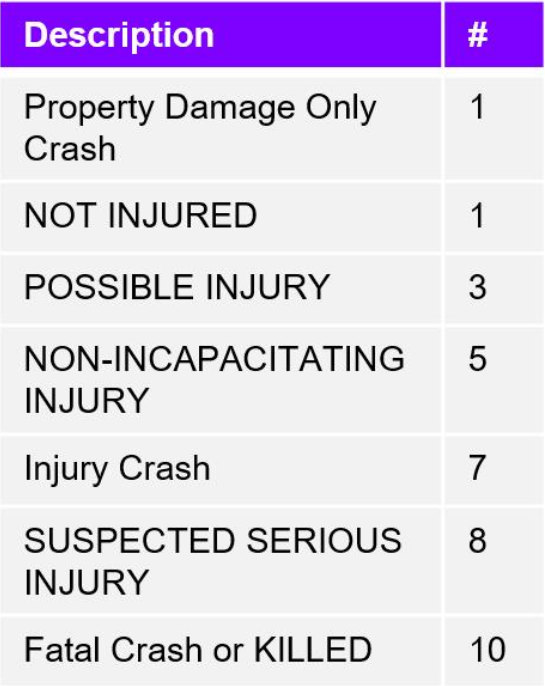